In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from glob import glob
import subprocess
import shutil
import monai.transforms as T

# For Brats

In [2]:
root_path = "/media/say26747/EC2426FA2426C782/Continual_learning_data/Brats_16_17/BRATS_splitted"


def load_brats_mets_dataset_paths(root):
    modalities_list = ["FLR", "T1w", "T1c", "T2w"]

    images_path = os.listdir(root)
    images_list = []

    for path in images_path:
        image_path = os.path.join(root, path)
        image_modalities_paths = []

        for modality in modalities_list:
            image_modalities_paths.append(
                os.path.join(image_path, f"{path}_{modality}.nii.gz")
            )

        seg_img = os.path.join(image_path, f"{path}_Seg.nii.gz")
        seg_merged_img = os.path.join(image_path, f"{path}_MERGED_Seg.nii.gz")

        images_list.append(
            {
                "image": image_modalities_paths,
                "label": seg_img,
                "merged_label": seg_merged_img,
                "name": path,
            }
        )

    return images_list


brats_paths = load_brats_mets_dataset_paths(root_path)

In [3]:
brats_paths[1]

{'image': ['/media/say26747/EC2426FA2426C782/Continual_learning_data/Brats_16_17/BRATS_splitted/BRATS_458/BRATS_458_FLR.nii.gz',
  '/media/say26747/EC2426FA2426C782/Continual_learning_data/Brats_16_17/BRATS_splitted/BRATS_458/BRATS_458_T1w.nii.gz',
  '/media/say26747/EC2426FA2426C782/Continual_learning_data/Brats_16_17/BRATS_splitted/BRATS_458/BRATS_458_T1c.nii.gz',
  '/media/say26747/EC2426FA2426C782/Continual_learning_data/Brats_16_17/BRATS_splitted/BRATS_458/BRATS_458_T2w.nii.gz'],
 'label': '/media/say26747/EC2426FA2426C782/Continual_learning_data/Brats_16_17/BRATS_splitted/BRATS_458/BRATS_458_Seg.nii.gz',
 'merged_label': '/media/say26747/EC2426FA2426C782/Continual_learning_data/Brats_16_17/BRATS_splitted/BRATS_458/BRATS_458_MERGED_Seg.nii.gz',
 'name': 'BRATS_458'}

In [4]:
transforms = T.Compose(
    [
        T.LoadImaged(keys=["image", "label", "merged_label"]),
        T.EnsureChannelFirstd(keys=["image", "label", "merged_label"]),
        T.Orientationd(keys=["image", "label", "merged_label"], axcodes="RAS"),
        T.Spacingd(
            keys=["image", "label", "merged_label"],
            pixdim=(1, 1, 1),
            mode=("bilinear", "nearest", "nearest"),
            padding_mode=("zeros", "zeros", "zeros"),
        ),
        # T.CropForegroundd(keys=["image", "label", "merged_label"], source_key="image", allow_smaller=True),
        T.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        T.AsChannelLastd(keys=["image", "label", "merged_label"]),
    ],
    lazy=True,
)


def process_image_brats(path):
    data = transforms(path)
    save_path = (
        "/media/say26747/EC2426FA2426C782/Continual_learning_data/Brats_16_17/finalized"
    )
    nib.save(
        nib.Nifti1Image(
            data["image"].astype(np.float32), affine=data["image"].meta["affine"]
        ),
        os.path.join(save_path, "images", f"{data['name']}.nii.gz"),
    )
    nib.save(
        nib.Nifti1Image(
            data["label"].squeeze().astype(np.uint8),
            affine=data["image"].meta["affine"],
        ),
        os.path.join(save_path, "labels_orig", f"{data['name']}.nii.gz"),
    )
    nib.save(
        nib.Nifti1Image(
            data["merged_label"].squeeze().astype(np.uint8),
            affine=data["image"].meta["affine"],
        ),
        os.path.join(save_path, "labels", f"{data['name']}.nii.gz"),
    )

In [5]:
results = Parallel(n_jobs=8)(
    delayed(process_image_brats)(path) for path in tqdm(brats_paths)
)

  0%|          | 0/484 [00:00<?, ?it/s]

## for brats for multi plane

In [7]:
root_brats_path = "/media/say26747/EC2426FA2426C782/Continual_learning_data/Brats_16_17/finalized/labels_orig"
all_data = sorted(glob(os.path.join(root_brats_path, "*.nii.gz")))
for path in tqdm(all_data):
    img = nib.load(path)
    data = img.get_fdata()
    data_new = data.copy()
    data_new[data_new == 1] = 0
    final_data = np.stack((data, data_new), axis=-1)
    save_path = path.replace("labels_orig", "labels_multiple")
    # print(save_path)
    nib.save(
        nib.Nifti1Image((final_data > 0).astype(np.uint8), affine=img.affine), save_path
    )

  0%|          | 0/484 [00:00<?, ?it/s]

(240, 240, 155, 2)


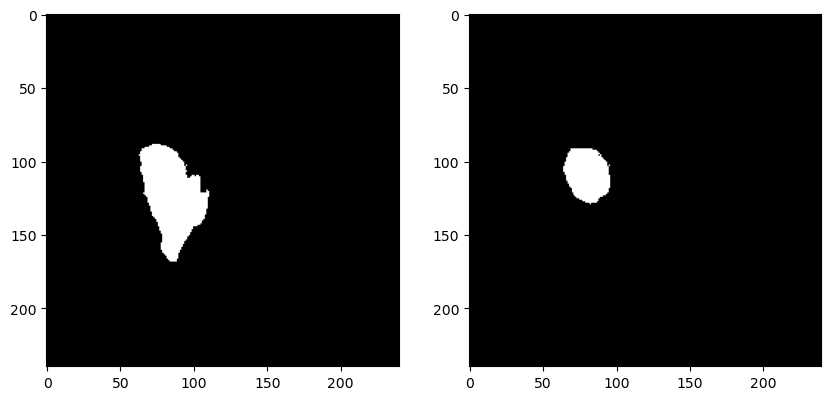

In [16]:
# just to check if it is correctly done
loaded_data = nib.load(
    "/media/say26747/EC2426FA2426C782/Continual_learning_data/Brats_16_17/finalized/labels_multiple/BRATS_001.nii.gz"
)
data = loaded_data.get_fdata()
print(data.shape)
# now plot the data in a subfigure, to check if it is correctly done
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(
    np.flip(np.transpose(data[:, :, 77, 0], axes=[1, 0]), axis=[1, 0]), cmap="gray"
)
ax[1].imshow(
    np.flip(np.transpose(data[:, :, 77, 1], axes=[1, 0]), axis=[1, 0]), cmap="gray"
)
plt.show()

# For Atlas

In [15]:
root_path = "/media/say26747/EC2426FA2426C782/Continual_learning_data/ATLAS/ATLAS_R2_skull_stripped"


def load_atlas_dataset_paths(root):
    modalities_list = ["T1w"]

    images_path = os.listdir(root)
    images_list = []

    for path in images_path:
        image_path = os.path.join(root, path)
        image_modalities_paths = []

        for modality in modalities_list:
            image_modalities_paths.append(
                os.path.join(image_path, f"{path}_{modality}.nii.gz")
            )

        seg_img = os.path.join(image_path, f"{path}_Seg.nii.gz")

        images_list.append(
            {
                "image": image_modalities_paths,
                "label": seg_img,
                "name": path,
            }
        )

    return images_list


atlas_paths = load_atlas_dataset_paths(root_path)

In [16]:
atlas_paths[1]

{'image': ['/media/say26747/EC2426FA2426C782/Continual_learning_data/ATLAS/ATLAS_R2_skull_stripped/sub-r049s028/sub-r049s028_T1w.nii.gz'],
 'label': '/media/say26747/EC2426FA2426C782/Continual_learning_data/ATLAS/ATLAS_R2_skull_stripped/sub-r049s028/sub-r049s028_Seg.nii.gz',
 'name': 'sub-r049s028'}

In [17]:
transforms = T.Compose(
    [
        T.LoadImaged(keys=["image", "label"]),
        T.EnsureChannelFirstd(keys=["image", "label"]),
        T.Orientationd(keys=["image", "label"], axcodes="RAS"),
        T.Spacingd(
            keys=["image", "label"],
            pixdim=(1, 1, 1),
            mode=("bilinear", "nearest"),
            padding_mode=("zeros", "zeros"),
        ),
        # T.CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        T.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        T.AsChannelLastd(keys=["image", "label"]),
    ],
    lazy=True,
)


def process_image_atlas(path):
    data = transforms(path)
    save_path = (
        "/media/say26747/EC2426FA2426C782/Continual_learning_data/ATLAS/finalized"
    )
    nib.save(
        nib.Nifti1Image(
            data["image"].squeeze().astype(np.float32),
            affine=data["image"].meta["affine"],
        ),
        os.path.join(save_path, "images", f"{data['name']}.nii.gz"),
    )
    nib.save(
        nib.Nifti1Image(
            data["label"].squeeze().astype(np.uint8),
            affine=data["image"].meta["affine"],
        ),
        os.path.join(save_path, "labels", f"{data['name']}.nii.gz"),
    )

In [18]:
results = Parallel(n_jobs=3)(
    delayed(process_image_atlas)(path) for path in tqdm(atlas_paths)
)

  0%|          | 0/655 [00:00<?, ?it/s]

# For ISLES

In [18]:
root_path = (
    "/media/say26747/EC2426FA2426C782/Continual_learning_data/ISLES_2015/ISLES_splitted"
)


def load_isles_dataset_paths(root):
    modalities_list = ["FLR", "T1w", "T2w", "DWI"]

    images_path = os.listdir(root)
    images_list = []

    for path in images_path:
        image_path = os.path.join(root, path)
        image_modalities_paths = []

        for modality in modalities_list:
            image_modalities_paths.append(
                os.path.join(image_path, f"{path}_{modality}.nii.gz")
            )

        seg_img = os.path.join(image_path, f"{path}_Seg.nii.gz")

        images_list.append(
            {
                "image": image_modalities_paths,
                "label": seg_img,
                "name": path,
            }
        )

    return images_list


isles_paths = load_isles_dataset_paths(root_path)

In [19]:
isles_paths[1]

{'image': ['/media/say26747/EC2426FA2426C782/Continual_learning_data/ISLES_2015/ISLES_splitted/patient_10/patient_10_FLR.nii.gz',
  '/media/say26747/EC2426FA2426C782/Continual_learning_data/ISLES_2015/ISLES_splitted/patient_10/patient_10_T1w.nii.gz',
  '/media/say26747/EC2426FA2426C782/Continual_learning_data/ISLES_2015/ISLES_splitted/patient_10/patient_10_T2w.nii.gz',
  '/media/say26747/EC2426FA2426C782/Continual_learning_data/ISLES_2015/ISLES_splitted/patient_10/patient_10_DWI.nii.gz'],
 'label': '/media/say26747/EC2426FA2426C782/Continual_learning_data/ISLES_2015/ISLES_splitted/patient_10/patient_10_Seg.nii.gz',
 'name': 'patient_10'}

In [20]:
transforms = T.Compose(
    [
        T.LoadImaged(keys=["image", "label"]),
        T.EnsureChannelFirstd(keys=["image", "label"]),
        T.Orientationd(keys=["image", "label"], axcodes="RAS"),
        T.Spacingd(
            keys=["image", "label"],
            pixdim=(1, 1, 1),
            mode=("bilinear", "nearest"),
            padding_mode=("zeros", "zeros"),
        ),
        # T.CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        T.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        T.AsChannelLastd(keys=["image", "label"]),
    ],
    lazy=True,
)


def process_image_isles(path):
    data = transforms(path)
    save_path = (
        "/media/say26747/EC2426FA2426C782/Continual_learning_data/ISLES_2015/finalized"
    )
    nib.save(
        nib.Nifti1Image(
            data["image"].squeeze().astype(np.float32),
            affine=data["image"].meta["affine"],
        ),
        os.path.join(save_path, "images", f"{data['name']}.nii.gz"),
    )
    nib.save(
        nib.Nifti1Image(
            data["label"].squeeze().astype(np.uint8),
            affine=data["image"].meta["affine"],
        ),
        os.path.join(save_path, "labels", f"{data['name']}.nii.gz"),
    )

In [21]:
results = Parallel(n_jobs=1)(
    delayed(process_image_isles)(path) for path in tqdm(isles_paths)
)

  0%|          | 0/28 [00:00<?, ?it/s]

# For MSSEG

In [24]:
root_path = (
    "/media/say26747/EC2426FA2426C782/Continual_learning_data/MSSEG_2016/MSSEG_splitted"
)


def load_msseg_dataset_paths(root):
    modalities_list = ["FLR", "T1w", "T1c", "T2w", "PDw"]

    images_path = os.listdir(root)
    images_list = []

    for path in images_path:
        image_path = os.path.join(root, path)
        image_modalities_paths = []

        for modality in modalities_list:
            image_modalities_paths.append(
                os.path.join(image_path, f"{path}_{modality}.nii.gz")
            )

        seg_img = os.path.join(image_path, f"{path}_Seg.nii.gz")

        images_list.append(
            {
                "image": image_modalities_paths,
                "label": seg_img,
                "name": path,
            }
        )

    return images_list


msseg_paths = load_msseg_dataset_paths(root_path)

In [25]:
msseg_paths[1]

{'image': ['/media/say26747/EC2426FA2426C782/Continual_learning_data/MSSEG_2016/MSSEG_splitted/test_center_08_patient_02/test_center_08_patient_02_FLR.nii.gz',
  '/media/say26747/EC2426FA2426C782/Continual_learning_data/MSSEG_2016/MSSEG_splitted/test_center_08_patient_02/test_center_08_patient_02_T1w.nii.gz',
  '/media/say26747/EC2426FA2426C782/Continual_learning_data/MSSEG_2016/MSSEG_splitted/test_center_08_patient_02/test_center_08_patient_02_T1c.nii.gz',
  '/media/say26747/EC2426FA2426C782/Continual_learning_data/MSSEG_2016/MSSEG_splitted/test_center_08_patient_02/test_center_08_patient_02_T2w.nii.gz',
  '/media/say26747/EC2426FA2426C782/Continual_learning_data/MSSEG_2016/MSSEG_splitted/test_center_08_patient_02/test_center_08_patient_02_PDw.nii.gz'],
 'label': '/media/say26747/EC2426FA2426C782/Continual_learning_data/MSSEG_2016/MSSEG_splitted/test_center_08_patient_02/test_center_08_patient_02_Seg.nii.gz',
 'name': 'test_center_08_patient_02'}

In [26]:
transforms = T.Compose(
    [
        T.LoadImaged(keys=["image", "label"]),
        T.EnsureChannelFirstd(keys=["image", "label"]),
        T.Orientationd(keys=["image", "label"], axcodes="RAS"),
        T.Spacingd(
            keys=["image", "label"],
            pixdim=(1, 1, 1),
            mode=("bilinear", "nearest"),
            padding_mode=("zeros", "zeros"),
        ),
        # T.CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        T.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        T.AsChannelLastd(keys=["image", "label"]),
    ],
    lazy=True,
)


def process_image_msseg(path):
    data = transforms(path)
    save_path = (
        "/media/say26747/EC2426FA2426C782/Continual_learning_data/MSSEG_2016/finalized"
    )
    nib.save(
        nib.Nifti1Image(
            data["image"].squeeze().astype(np.float32),
            affine=data["image"].meta["affine"],
        ),
        os.path.join(save_path, "images", f"{data['name']}.nii.gz"),
    )
    nib.save(
        nib.Nifti1Image(
            data["label"].squeeze().astype(np.uint8),
            affine=data["image"].meta["affine"],
        ),
        os.path.join(save_path, "labels", f"{data['name']}.nii.gz"),
    )

In [27]:
results = Parallel(n_jobs=4)(
    delayed(process_image_msseg)(path) for path in tqdm(msseg_paths)
)

  0%|          | 0/53 [00:00<?, ?it/s]

# For WMH

In [40]:
root_path = "/media/say26747/EC2426FA2426C782/Continual_learning_data/WMH/WMH_splitted"
images_path = os.listdir(root_path)

for path in tqdm(images_path):
    image_path = os.path.join(root_path, path)
    orig_data = nib.load(os.path.join(image_path, f"{path}_FLR.nii.gz"))
    t1_data = nib.load(os.path.join(image_path, f"{path}_T1w.nii.gz"))
    nib.save(
        nib.Nifti1Image(
            t1_data.get_fdata().astype(np.float32), affine=orig_data.affine
        ),
        os.path.join(image_path, f"{path}_T1w.nii.gz"),
    )

  0%|          | 0/60 [00:00<?, ?it/s]

In [43]:
root_path = "/media/say26747/EC2426FA2426C782/Continual_learning_data/WMH/WMH_splitted"


def load_wmh_dataset_paths(root):
    modalities_list = ["FLR", "T1w"]

    images_path = os.listdir(root)
    images_list = []

    for path in images_path:
        image_path = os.path.join(root, path)
        image_modalities_paths = []

        for modality in modalities_list:
            image_modalities_paths.append(
                os.path.join(image_path, f"{path}_{modality}.nii.gz")
            )

        seg_img = os.path.join(image_path, f"{path}_Seg.nii.gz")

        images_list.append(
            {
                "image": image_modalities_paths,
                "label": seg_img,
                "name": path,
            }
        )

    return images_list


wmh_paths = load_wmh_dataset_paths(root_path)

In [44]:
wmh_paths[1]

{'image': ['/media/say26747/EC2426FA2426C782/Continual_learning_data/WMH/WMH_splitted/patient_51/patient_51_FLR.nii.gz',
  '/media/say26747/EC2426FA2426C782/Continual_learning_data/WMH/WMH_splitted/patient_51/patient_51_T1w.nii.gz'],
 'label': '/media/say26747/EC2426FA2426C782/Continual_learning_data/WMH/WMH_splitted/patient_51/patient_51_Seg.nii.gz',
 'name': 'patient_51'}

In [45]:
transforms = T.Compose(
    [
        T.LoadImaged(keys=["image", "label"]),
        T.EnsureChannelFirstd(keys=["image", "label"]),
        T.Orientationd(keys=["image", "label"], axcodes="RAS"),
        T.Spacingd(
            keys=["image", "label"],
            pixdim=(1, 1, 1),
            mode=("bilinear", "nearest"),
            padding_mode=("zeros", "zeros"),
        ),
        # T.CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        T.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        T.AsChannelLastd(keys=["image", "label"]),
    ],
    lazy=False,
)


def process_image_wmh(path):
    data = transforms(path)
    save_path = "/media/say26747/EC2426FA2426C782/Continual_learning_data/WMH/finalized"
    nib.save(
        nib.Nifti1Image(
            data["image"].squeeze().astype(np.float32),
            affine=data["image"].meta["affine"],
        ),
        os.path.join(save_path, "images", f"{data['name']}.nii.gz"),
    )
    nib.save(
        nib.Nifti1Image(
            data["label"].squeeze().astype(np.uint8),
            affine=data["image"].meta["affine"],
        ),
        os.path.join(save_path, "labels", f"{data['name']}.nii.gz"),
    )

In [46]:
results = Parallel(n_jobs=1)(
    delayed(process_image_wmh)(path) for path in tqdm(wmh_paths)
)

  0%|          | 0/60 [00:00<?, ?it/s]

In [41]:
path = "/media/say26747/EC2426FA2426C782/Continual_learning_data/WMH/WMH_splitted/patient_0"
print(nib.load(os.path.join(path, "patient_0_FLR.nii.gz")).header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 240 240  48   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.9583333  0.95833325 2.9999993  1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.031557195
quatern_c       : -0.21605444
quatern_d       : 0.9756906
qoffset_x       : 118.610664
qoffset_y    

In [42]:
print(nib.load(os.path.join(path, "patient_0_T1w.nii.gz")).header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 240 240  48   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.9583333  0.95833325 2.9999993  1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.031557195
quatern_c       : -0.21605444
quatern_d       : 0.9756906
qoffset_x       : 118.610664
qoffset_y    

In [37]:
print(nib.load(os.path.join(path, "3DT1.nii.gz")).header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 176   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.     0.9375 0.9375 1.     0.     0.     0.     0.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : aligned
sform_code      : scanner
quatern_b       : -0.5
quatern_c       : 0.5
quatern_d       : -0.5
qoffset_x       : -88.235
qoffset_y       : 153.922
qoffset_z       : 100.503
srow_x  